<a href="https://colab.research.google.com/github/sournara/Computer_Vision_Study/blob/main/TensorFlow/TensorFlow_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 학습 코드를 실행하기 전에 [런타임]-[런타임 유형 변경]에서 하드웨어 가속기를 [GPU]로 설정한다.
### **데이터 세트 다운로드**
- 딥러닝 모델 학습 과정에서 필요한 데이터 세트를 불러온다.

In [1]:
!git clone https://github.com/ndb796/korean_face_age_dataset custom_korean_family_dataset_resolution_128

Cloning into 'custom_korean_family_dataset_resolution_128'...
remote: Enumerating objects: 27577, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 27577 (delta 0), reused 6 (delta 0), pack-reused 27571
Receiving objects: 100% (27577/27577), 76.04 MiB | 14.44 MiB/s, done.
Updating files: 100% (53072/53072), done.


### **라이브러리 불러오기(Load Libraries)**
- 딥러닝 모델 학습 과정에서 필요한 라이브러리를 불러온다.

In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

### **데이터 세트 불러오기(Load Dataset)**
1. **데이터 증진(data augmentation)**을 명시하여 초기화할 수 있다.
    - 이미지를 불러올 때 어떤 방법(회전, 자르기, 뒤집기 등)을 사용할 것인지 명시한다.
2. 이후에 **flow()**를 이용하여 실질적으로 데이터를 불러올 수 있다.
    - 어떤 데이터를 사용할 것인지, 배치 크기(batch size), 데이터 셔플(shuffle) 여부 등을 명시한다.
    - **next() 함수**를 이용하여 numpy array 형태로 데이터를 배치 단위로 얻을 수 있다.

- **Reference** : https://github.com/ndb796/korean_face_age_classification (AI Hub)

In [3]:
"""
> [Function] Parse the metadata.
* image_age_list[0] = ["F0001_AGE_D_18_a1.jpg] = "a"
* image_age_list[1] = ["F0001_AGE_D_18_a2.jpg] = "a"
* image_age_list[2] = ["F0001_AGE_D_18_a3.jpg] = "a"
* image_age_list[3] = ["F0001_AGE_D_18_a4.jpg] = "a"
* image_age_list[4] = ["F0001_AGE_D_18_b1.jpg] = "b"
...
"""
def parsing(meta_data) :
    image_age_list = []
    # iterate all rows in the metadata file
    for idx, row in meta_data.iterrows() :
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

class ListGenerator() :
    def __init__(self, meta_data, image_directory) :
        self.meta_data = meta_data
        self.image_directory = image_directory

        # process the meta data
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a" : "0-6 years old",
            "b" : "7-12 years old",
            "c" : "13-19 years old",
            "d" : "20-30 years old",
            "e" : "31-45 years old",
            "f" : "46-55 years old",
            "g" : "56-66 years old",
            "h" : "67-80 years old"
        }

    def get_list(self) :
        paths = []
        labels = []
        for idx in range(len(self.meta_data)) :
            image_path, age_class = self.image_age_list[idx]
            path = os.path.join(self.image_directory, image_path)
            label = self.age_class_to_label[age_class]
            paths.append(path)
            labels.append(label)

        return paths, labels

train_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_128/train_images"

val_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_val_dataset.csv"
val_meta_data = pd.read_csv(val_meta_data_path)
val_image_directory = "./custom_korean_family_dataset_resolution_128/val_images"

test_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_test_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "./custom_korean_family_dataset_resolution_128/test_images"

train_list = ListGenerator(train_meta_data, train_image_directory).get_list()
train_dataframe = pd.DataFrame({"path" : train_list[0], "label" : train_list[1]})

val_list = ListGenerator(val_meta_data, val_image_directory).get_list()
val_dataframe = pd.DataFrame({"path" : val_list[0], "label" : val_list[1]})

test_list = ListGenerator(test_meta_data, test_image_directory).get_list()
test_dataframe = pd.DataFrame({"path" : test_list[0], "label" : test_list[1]})

print(train_dataframe)

                                                    path            label
0      ./custom_korean_family_dataset_resolution_128/...    0-6 years old
1      ./custom_korean_family_dataset_resolution_128/...    0-6 years old
2      ./custom_korean_family_dataset_resolution_128/...    0-6 years old
3      ./custom_korean_family_dataset_resolution_128/...    0-6 years old
4      ./custom_korean_family_dataset_resolution_128/...   7-12 years old
...                                                  ...              ...
10020  ./custom_korean_family_dataset_resolution_128/...   7-12 years old
10021  ./custom_korean_family_dataset_resolution_128/...   7-12 years old
10022  ./custom_korean_family_dataset_resolution_128/...  13-19 years old
10023  ./custom_korean_family_dataset_resolution_128/...  13-19 years old
10024  ./custom_korean_family_dataset_resolution_128/...  13-19 years old

[10025 rows x 2 columns]


In [8]:
train_generator = ImageDataGenerator(
    rescale = 1 / 255.,
    horizontal_flip = True,
    validation_split = 0.2
)
test_generator = ImageDataGenerator(rescale = 1 / 255.)

train_flow = train_generator.flow_from_dataframe(
    dataframe = train_dataframe,
    x_col = "path",
    y_col = "label",
    shuffle = True,
    target_size = (224, 224),
    class_mode = "categorical",
    batch_size = 64
)
val_flow = train_generator.flow_from_dataframe(
    dataframe = val_dataframe,
    x_col = "path",
    y_col = "label",
    shuffle = True,
    target_size = (224, 224),
    class_mode = "categorical",
    batch_size = 64
)
test_flow = test_generator.flow_from_dataframe(
    dataframe = test_dataframe,
    x_col = "path",
    y_col = "label",
    shuffle = False,
    target_size = (224, 224),
    class_mode = "categorical",
    batch_size = 64
)

Found 10025 validated image filenames belonging to 8 classes.
Found 1539 validated image filenames belonging to 8 classes.
Found 1504 validated image filenames belonging to 8 classes.


### **데이터 시각화(Data Visualization)**

['13-19 years old', '67-80 years old', '0-6 years old', '0-6 years old']


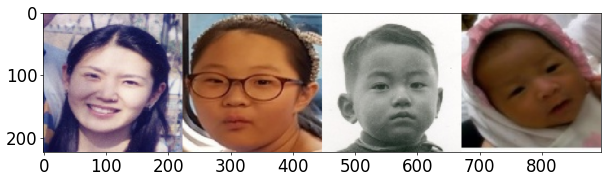

In [9]:
label_to_age = {
    0 : "0-6 years old",
    1 : "7-12 years old",
    2 : "13-19 years old",
    3 : "20-30 years old",
    4 : "31-45 years old",
    5 : "46-55 years old",
    6 : "56-66 years old",
    7 : "67-80 years old"
}

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size' : 20})

images, targets = next(train_flow)

print([label_to_age[x] for x in np.argmax(targets[:4], axis = 1)])
plt.imshow(np.concatenate((images[0], images[1], images[2], images[3]), axis = 1))
plt.show()

### **딥러닝 모델 학습(Training)**
- 사전 학습된(pre-trained) 모델을 이용하여 가지고 있는 데이터 세트에 대한 학습이 가능하다.
    - **include_top** : 네트워크 뒤에 FC(fully-connected) 레이어를 포함하는지 여부
    - **weights** : None 혹은 "imagenet"
    - 네트워크의 마지막에 FC 레이어를 적용하여 클래스 개수를 일치시킨다.

In [11]:
model = Sequential()
pretrained_model = InceptionV3(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet'
)
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(8, activation = 'softmax'))
# model.summary()

In [13]:
learning_rate = 0.001

# 학습 준비 단계(compile)
model.compile(
    optimizer = optimizers.SGD(learning_rate = learning_rate),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
# 학습 수행
history = model.fit(
    train_flow,
    epochs = 15,
    validation_data = val_flow
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 198s 778ms/step - accuracy: 0.2863 - loss: 1.9355 - val_accuracy: 0.4139 - val_loss: 1.4889
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 90s 425ms/step - accuracy: 0.5385 - loss: 1.2664 - val_accuracy: 0.4418 - val_loss: 1.4696
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 68s 427ms/step - accuracy: 0.6639 - loss: 0.9647 - val_accuracy: 0.4574 - val_loss: 1.4389
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 68s 429ms/step - accuracy: 0.7443 - loss: 0.7708 - val_accuracy: 0.4847 - val_loss: 1.3600
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 68s 429ms/step - accuracy: 0.8049 - loss: 0.6232 - val_accuracy: 0.4808 - val_loss: 1.4131
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 435ms/step - accuracy: 0.8513 - loss: 0.5237 - val_accuracy: 0.4847 - val_loss: 1.3993
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 433ms/step - accuracy: 0.8906 - loss: 0.4192 - val_accuracy: 0.4880 - val_loss: 1.4238
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 430ms/step - accuracy: 0.9162 - loss: 0.3525 - va

### **학습 결과 확인하기**
- 학습 결과를 시각화하여 정상적으로 모델이 학습되었는지 확인한다.

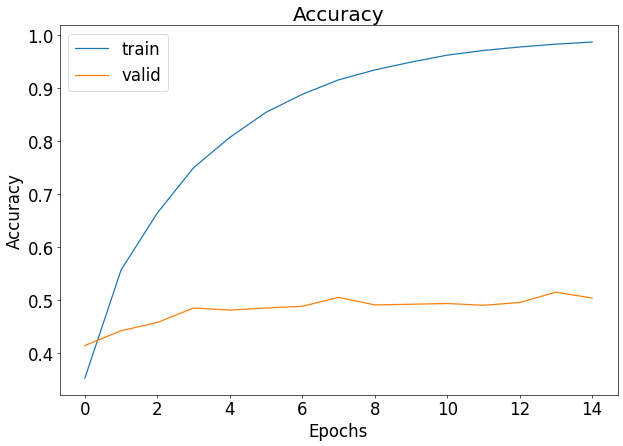

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.legend(['train', 'valid'])
plt.show()

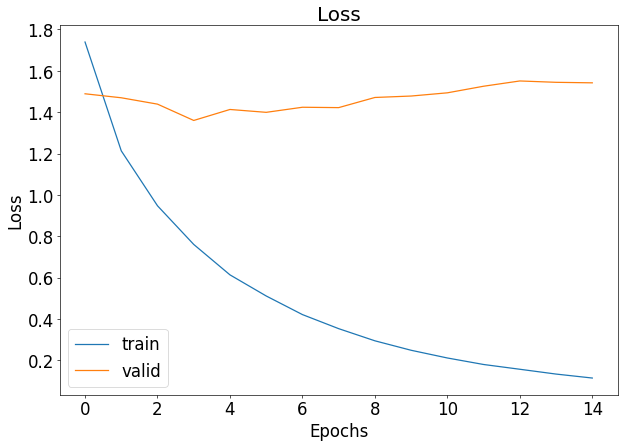

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend(['train', 'valid'])
plt.show()

In [16]:
# 학습된 모델 테스트
test_history = model.evaluate(test_flow)
test_loss, test_accuracy = test_history

print(f"Test loss : {test_loss:.8f}")
print(f"Test accuracy : {test_accuracy * 100.:.2f}%")

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step - accuracy: 0.4948 - loss: 1.4279
Test loss : 1.40384710
Test accuracy : 51.40%
